In [3]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import tqdm
from matplotlib import pyplot as plt


In [4]:
datadir = '../../datasets/foldtree2/'

In [5]:

#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )


reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [6]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [7]:
mkdirs = False
if mkdirs == True:
    #make a structure alignment directory
    if not os.path.exists( 'struct_align' ):
        os.makedirs( 'struct_align' )
    
    #make a directory for each cluster representative
    for rep in reps['repId']:
        if not os.path.exists( datadir +'struct_align/' + rep  ):
            os.makedirs(datadir + 'struct_align/' + rep  )
        if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
            os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
            

In [8]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
    n = 5
    for rep in tqdm.tqdm(reps.repId.unique() ):
        subdf = reps[ reps['repId'] == rep ]
        if len(subdf) < n:
            n = len(subdf)
        subdf = subdf.sample( n = n  )
        subdf = subdf.head( n )
        #download the structures
        for uniID in subdf['entryId']:
            AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [9]:
#for each folder in struct_align, align the structures with all vs all using foldseek
from src import foldseek2tree
aln_structs = False
if aln_structs == True:
    for rep in tqdm.tqdm(reps.repId.unique() ):
        #align the structures
        foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [10]:
import foldtree2_ecddcd as ft2
import torch
#get all example structures in a directory
structs = glob.glob('families/fsx1/*.pdb')
print(structs)

ndim = 844
converter = ft2.PDB2PyG()

with open( 'model.pkl' , 'rb' ) as f:
    encoder,decoder = pickle.load( f )

alphabetsize = encoder.vector_quantizer.embedding_dim

#use the encoder to make a fasta file
#encoder = ft2.HeteroGAE_Encoder(in_channels=ndim, hidden_channels=[ 400 ]*3 , out_channels=250, metadata=converter.metadata , num_embeddings=248, commitment_cost=1 , encoder_hidden=500 , EMA = True , reset_codes = False )
#encoder_save = 'encoder_mk2_aa_50_AAq_transformermk3_248'
#encoder.load_state_dict( torch.load( encoder_save ) )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = encoder.to(device)
encoder.eval()


['families/fsx1/6EGU.pdb', 'families/fsx1/5mf1mono.pdb', 'families/fsx1/WP_163487151_Hborinquense.pdb', 'families/fsx1/4GSX.pdb', 'families/fsx1/WP_007110832_Naltunense.pdb', 'families/fsx1/4OJC_model.pdb', 'families/fsx1/2ala.pdb', 'families/fsx1/1OAN.pdb', 'families/fsx1/2I69.pdb', 'families/fsx1/6E18.pdb', 'families/fsx1/WP_049937247_Hnatans.pdb', 'families/fsx1/3n43.pdb', 'families/fsx1/5ow3.pdb', 'families/fsx1/WP_058826362_Haloferax.pdb', 'families/fsx1/1SVB.pdb', 'families/fsx1/fsxA11_monomer.pdb', 'families/fsx1/1rer.pdb', 'families/fsx1/4HJ1.pdb']


HeteroGAE_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): SAGEConv(844, 400, aggr=mean)
      (res_backbonerev_res): SAGEConv(844, 400, aggr=mean)
      (res_contactPoints_res): SAGEConv(844, 400, aggr=mean)
      (res_hbond_res): SAGEConv(844, 400, aggr=mean)
    )
    (1-2): 2 x ModuleDict(
      (res_backbone_res): SAGEConv(400, 400, aggr=mean)
      (res_backbonerev_res): SAGEConv(400, 400, aggr=mean)
      (res_contactPoints_res): SAGEConv(400, 400, aggr=mean)
      (res_hbond_res): SAGEConv(400, 400, aggr=mean)
    )
  )
  (bn): BatchNorm1d(844, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (out_dense): Sequential(
    (0): Linear(in_features=420, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): Tanh()
  )
  (vector_quantizer): VectorQuantizerE

In [18]:

import importlib
importlib.reload(ft2)
from torch_geometric.data import DataLoader

struct_dat = ft2.StructureDataset('structs_structalign_new.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encoder.eval()

encode_alns = False
if encode_alns == True:
        
    def databatch2list(loader):
        for data in loader:
            data = data.to_data_list()
            for d in data:
                yield d
    encoder_loader = databatch2list(encoder_loader)
    encoder.encode_structures_fasta(encoder_loader , 'aln_encoded.fasta' )

/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
encoded_fasta = '/home/dmoi/projects/foldtree2/aln_encoded.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    for line in tqdm.tqdm(f):
        if line[0] == '>' and line[-1] == '\n':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )
print(encoded_df)

25060it [00:00, 376531.91it/s]

                                                          seq
protid                                                       
A0A812SDZ8  8BB:%%*þÿþ%*86\tB...
A0A2H3RVX8  6ûG"ú:6úþÿB""&GG6*:G6B:...
A0A6P0WAX6  G6G%"%E&E\tú&ú:\t\tþ...
A0A4Z2IJW5  7\t\tú\"ú*7:8BBG*6\t"...
A0A2T4CPV3  úGGú"GúúBúB%BEBBBú"&""...
...                                                       ...
A0A428YLD3  G%û%%%7û%û%:BBú*%ûBBú...
A0A1W6N4K7  :%"úBúBBB%:%7B""&B7"&E:"BB...
A0A444X584  BBGûBB6úúúBG:::%B8úúGBþú:8...
A0A6N8YWK1  B""ú"\tû\t":"B:%::"66"ú"...
A0A0D0GYU6  &û1\t\tÿ1""\tÿE...

[12529 rows x 1 columns]


In [20]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary
#z is not used currently...

replace_dict = { '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) , '"':chr(248) , '#':chr(247) }

In [21]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq
protid                                                       
A0A812SDZ8  8BB:%%*þÿþ%*86\tB...
A0A2H3RVX8  6ûGøú:6úþÿBøø&GG6*:G6B:...
A0A6P0WAX6  G6G%ø%E&E\tú&ú:\t\tþ...
A0A4Z2IJW5  7\t\tú\øú*7:8BBG*6\tø...
A0A2T4CPV3  úGGúøGúúBúB%BEBBBúø&øø...
...                                                       ...
A0A428YLD3  G%û%%%7û%û%:BBú*%ûBBú...
A0A1W6N4K7  :%øúBúBBB%:%7Bøø&B7ø&E:øBB...
A0A444X584  BBGûBB6úúúBG:::%B8úúGBþú:8...
A0A6N8YWK1  Bøøúø\tû\tø:øB:%::ø66øúø...
A0A0D0GYU6  &û1\t\tÿ1øø\tÿE...

[12529 rows x 1 columns]


In [22]:
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )
print(encoded_df.head())

                                                          seq  \
protid                                                          
A0A812SDZ8  8BB:%%*þÿþ%*86\tB...   
A0A2H3RVX8  6ûGøú:6úþÿBøø&GG6*:G6B:...   
A0A6P0WAX6  G6G%ø%E&E\tú&ú:\t\tþ...   
A0A4Z2IJW5  7\t\tú\øú*7:8BBG*6\tø...   
A0A2T4CPV3  úGGúøGúúBúB%BEBBBúø&øø...   

                                                          ord  \
protid                                                          
A0A812SDZ8  [6, 6, 17, 19, 56, 20, 20, 22, 66, 66, 19, 58,...   
A0A2H3RVX8  [6, 6, 54, 20, 1, 2, 251, 71, 18, 2, 17, 248, ...   
A0A6P0WAX6  [6, 6, 3, 71, 54, 16, 14, 71, 37, 3, 248, 19, ...   
A0A4Z2IJW5  [6, 6, 16, 8, 2, 22, 55, 9, 22, 21, 9, 250, 9,...   
A0A2T4CPV3  [6, 6, 250, 18, 71, 71, 22, 250, 248, 8, 21, 1...   

                                                         hex2  
protid                        

In [23]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
    char_set = char_set.union( set( seq ) )
char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )


['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '%', '&', '*', '1', '6', '7', '8', ':', 'B', 'E', 'G', 'ø', 'ú', 'û', 'þ', 'ÿ']
38


In [24]:

cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')

fident_thresh = .3

submat =  np.zeros((256,256))

background_freq = np.zeros(len(char_set))

q_mat = np.zeros((256,256))

seqcount = 0
for rep in tqdm.tqdm(alnfiles ):

    q_mat_chunk = np.zeros((256,256))
    submat_chunk = np.zeros((256,256))
    alncount = 0
    #load the all vs all aln
    aln_df = pd.read_table(rep)
    aln_df.columns = cols
    #load the embedding of the structures
    q = aln_df['query'].unique()
    t = aln_df['target'].unique()
    
    seqset = set()
    representative = rep.split('/')[-2]
    for q in aln_df['query'].unique():
        for t in aln_df['target'].unique():
            if q != t:
                #align the structures
                aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
                if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
                    aln = aln.iloc[0]
                    qaln = aln.qaln
                    taln = aln.taln
                    qaccession = q.split( '.' )[0]
                    taccession = t.split( '.' )[0]

                    if qaccession in encoded_df.index and taccession in encoded_df.index:
                        qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
                        tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

                        if qaccession not in seqset:
                            background_freq += np.array([ qz.count( c ) for c in char_set ])
                            seqset.add( qaccession )
                            seqcount += len(qz)
                        
                        if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
                            qz = iter(qz)
                            tz = iter(tz)

                            #transfer the alignments to the embeddings                    
                            qaln_ft2, taln_ft2 = [], []

                            for q_char in qaln:
                                if q_char == '-':
                                    qaln_ft2.append(None)
                                else:
                                    qaln_ft2.append(ord(next(qz)))
                                   
                            for t_char in taln.strip():
                                if t_char == '-':
                                    taln_ft2.append(None)
                                else:
                                    taln_ft2.append(ord(next(tz)))

                            alnzip = list(zip( qaln_ft2 , taln_ft2 ))
                            alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
                            #normalize by size of alignment
                            
                            submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
                            #normalize by size of alignment and number of pairs
                            alncount += 1
                            q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
        if alncount > 0:
            q_mat += (q_mat_chunk / alncount)
            submat += (submat_chunk / alncount)



100%|████████████████████████████████████████████████████████████████████████████| 3691/3691 [00:44<00:00, 82.39it/s]


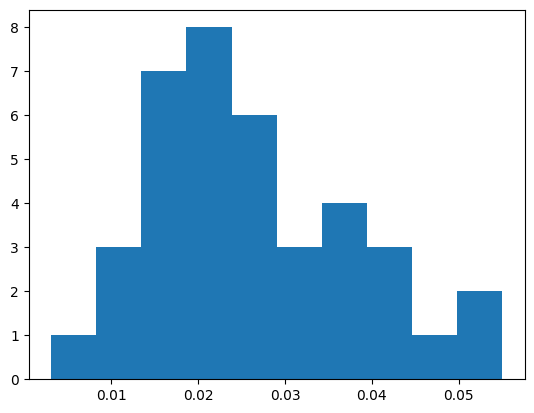

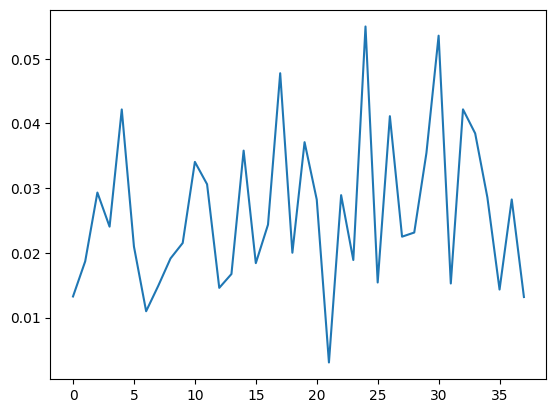

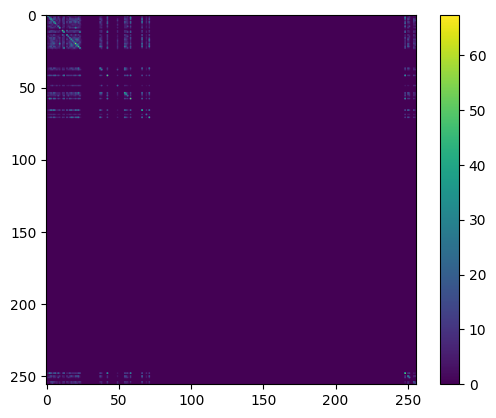

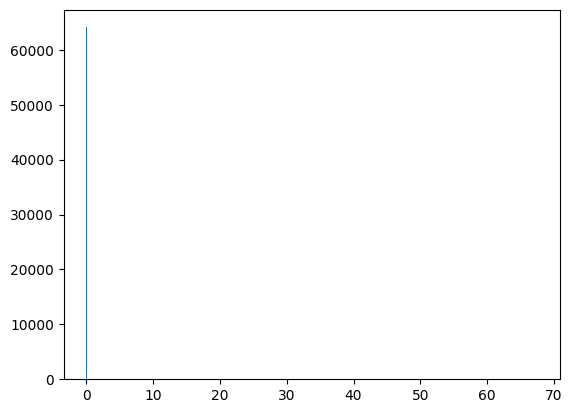

In [25]:
background_freq = background_freq / np.sum( background_freq )
q_mat = q_mat + q_mat.T
plt.hist( background_freq )
plt.show()
plt.plot( background_freq )
plt.show()

#ploT QMAT

plt.imshow(q_mat)
plt.colorbar()
plt.show()
plt.hist(q_mat.flatten() , bins = 400)
plt.show()


In [54]:
print( len(background_freq))

38


In [74]:
#normalize qmat so that each row and column sums to 1


np.fill_diagonal(q_mat, 0 )


for i in range(256):
    if np.sum( q_mat[i,:] ) > 0:
        q_mat[i,:] = q_mat[i,:] / np.sum( q_mat[i,:] )
        q_mat[:,i] = q_mat[i,:]
    else:
        q_mat[i,i] = 1
        q_mat[i,i] = 1


In [75]:
alphabet = [ord(c) for c in char_set]
sub_qmat = q_mat[alphabet,:]
sub_qmat = sub_qmat[:,alphabet]


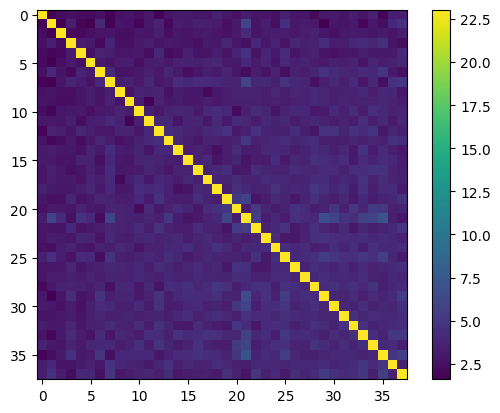

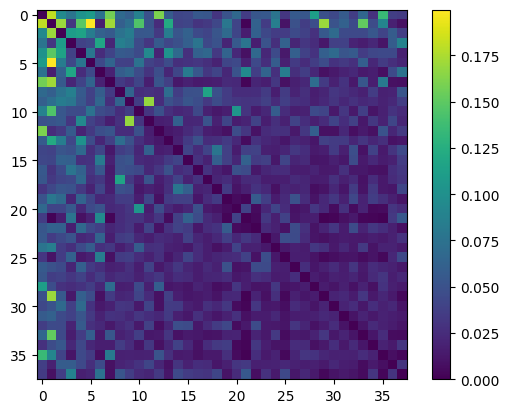

In [76]:
#divide the columns of qmat by the sum of the column

plt.imshow(-np.log(sub_qmat+10**-10))
plt.colorbar()
plt.show()
plt.imshow(sub_qmat)
plt.colorbar()
plt.show()

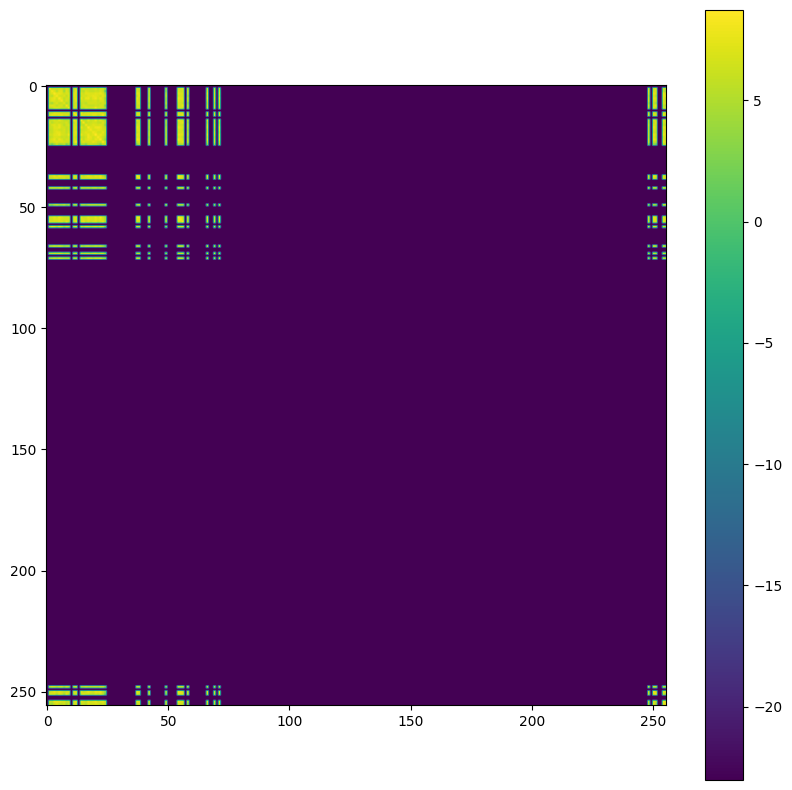

(array([6.4092e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 1.7000e+01, 8.4000e+01, 9.3500e+02, 4.0400e+02]),
 array([-23.02585093, -21.43848768, -19.85112443, -18.26376118,
        -16.67639793, -15.08903468, -13.50167143, -11.91430817,
        -10.32694492,  -8.73958167,  -7.15221842,  -5.56485517,
         -3.97749192,  -2.39012867,  -0.80276542,   0.78459783,
          2.37196108,   3.95932433,   5.54668758,   7.13405084,
          8.72141409]),
 <BarContainer object of 20 artists>)

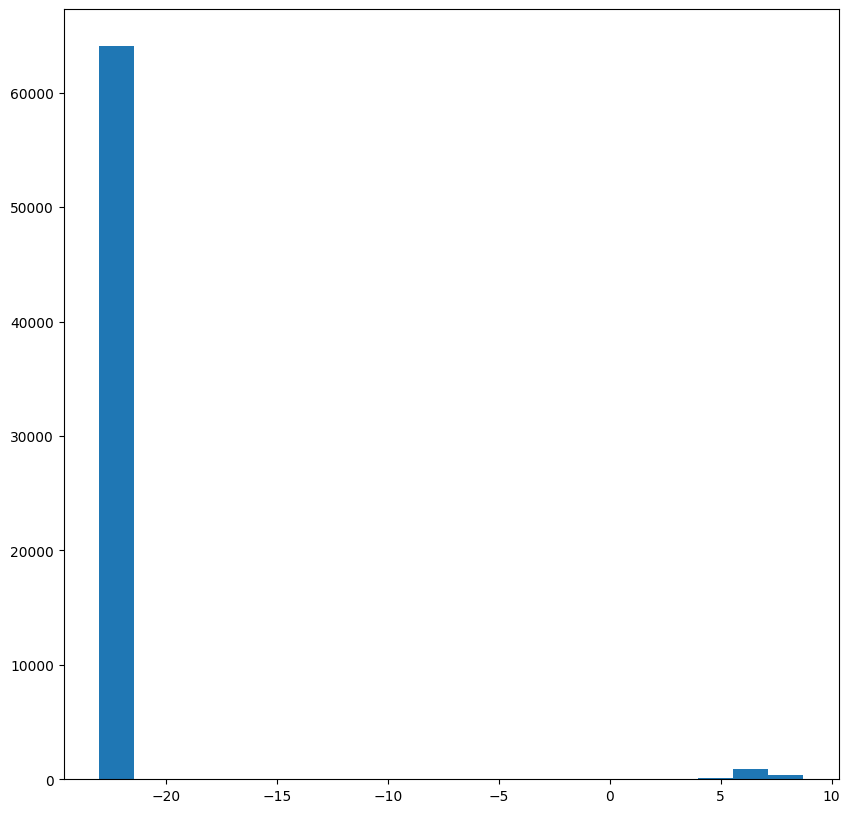

In [30]:
plt.figure( figsize=(10,10))
plt.imshow(np.log(submat + 10**-10 ) )
plt.colorbar()

plt.show()
plt.figure( figsize=(10,10))

plt.hist( np.log( submat.flatten() + 10 **-10 )  , bins = 20)

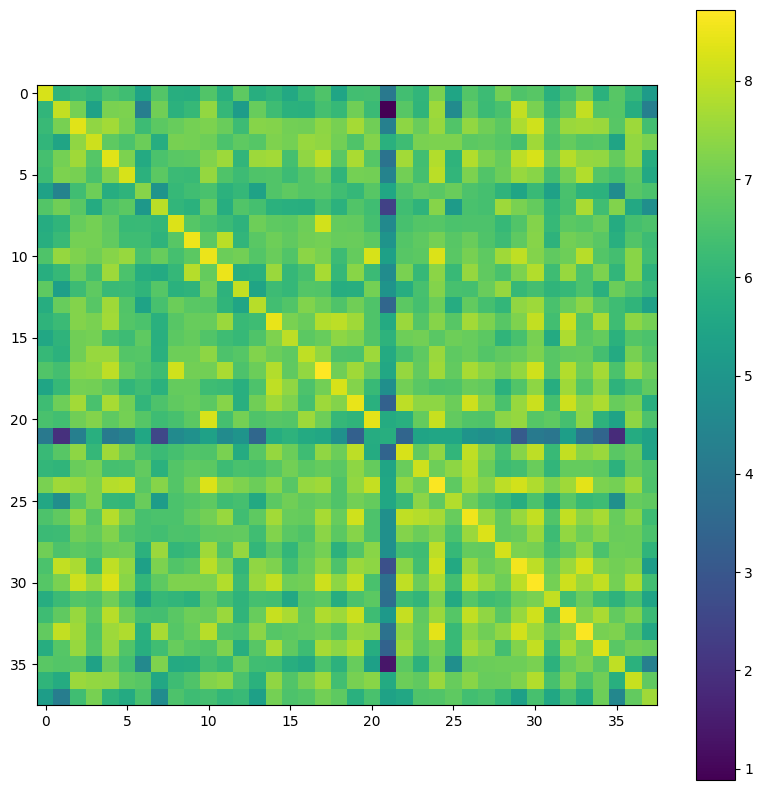

In [31]:
#remove zero rows and columns for visualization

vismat = submat[alphabet, : ]
vismat = vismat[ :, alphabet ]

plt.figure( figsize=(10,10))
plt.imshow(np.log(vismat + 10**-10 ) )
plt.colorbar()


In [32]:
#mafft matrix file example max 248 char
"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
    if len(hexnum) == 3:
        return hexnum[0:2] + '0' + hexnum[2]
    else:
        return hexnum

def output_mafft_matrix( submat , outpath='mafft_submat.mtx' ):
    with open(outpath, 'w') as f:
        for i in range(submat.shape[0]):
            for j in range(submat.shape[1]):
                if i <= j:
                    
                    stringi = chr(i)
                    stringj = chr(j)
                    
                    if stringi in replace_dict.keys():
                        stringi = replace_dict[stringi]
                    if stringj in replace_dict.keys():
                        stringj = replace_dict[stringj]
                    
                    i = ord(stringi)
                    j = ord(stringj)

                    hexi = formathex(hex(i))
                    hexj = formathex(hex(j))
                    
                    if submat[i,j] > 1:
                        f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
                    #else:
                    #    f.write( f'{hexi} {hexj} {0.0} # '+ stringi + 'x' + stringj + ' \n' )
output_mafft_matrix( submat , outpath='mafft_submat.mtx' )


In [33]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [34]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
    cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def mafft_hex2fasta( intext , outfasta ):
    #% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    


def fasta2hex( intext , outfasta ):
    #% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    

def normal_mafft( infasta , outaln ):
    cmd = f'mafft --anysymbol {infasta} > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln



def struct2sequence(structfile):
    parser = PDB.PDBParser()
    structure = parser.get_structure('struct', structfile)
    seq = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    seq += residue.get_resname()
    return seq

In [35]:
import glob
structs = glob.glob('families/fsx1/*.pdb')


In [36]:
#make normal fasta

with open( 'fsx1_example.fasta', 'w') as f:
    for s in structs:
        seq =  struct2sequence(s)
        identifier = s.split('/')[-1].split('.')[0]
        f.write('>' + identifier + '\n' + seq + '\n')


/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6734.
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record ' ' at line 19
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3009
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3807
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3025
  warnings.warn(
/home/dmoi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarn

In [37]:

def loader( structlist , converter):
    for struct in tqdm.tqdm(structlist):
        try:
            data = converter.struct2pyg( struct )
            yield data
        except:
            print('error')
            continue

loader = loader( structs , converter )
encoder.encode_structures_fasta( loader , 'fsx1_encoded.fasta')


2it [00:01,  1.50it/s]

error


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]
17it [00:11,  1.47it/s]


'fsx1_encoded.fasta'

In [38]:
aln = normal_mafft( 'fsx1_example.fasta' , 'fsx1_example.aln' )
#print aln

with open('fsx1_example.aln', 'r') as f:
    for line in f:
        print(line)


t = normal_iqtree( 'fsx1_example.aln')

mafft --anysymbol fsx1_example.fasta > fsx1_example.aln


inputfile = orig
18 x 2364 - 0 p
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 1404 ambiguous characters.
    1 / 18
done.

Constructing a UPGMA tree (efffree=0) ... 
   10 / 18
done.

Progressive alignment 1/2... 
STEP    13 / 17 
Reallocating..done. *alloclen = 5806
STEP    17 / 17 
done.

Making a distance matrix from msa.. 
    0 / 18
done.

Constructing a UPGMA tree (efffree=1) ... 
   10 / 18
done.

Progressive alignment 2/2... 
STEP    14 / 17 
Reallocating..done. *alloclen = 6035
STEP    17 / 17 
done.

disttbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring 

>6EGU

------------------------------CYSSERGLULEUILEGLNALASERSER-AR

GILETHRTHRCYSSERTHR------------------------------------THR--

----LY---------------SCYS-----ARGLEUSERGLY-------------THRA-

-LALEUILEA-------RGALAGLYSER------------VAL---GLYALA--------

-GLU---ALACYSLEUMETLEULYSGLYVALLYSGLUASPGL------NTHRLY------

---------------------------------------------------SPHELE---

---------------ULYSILELYS------------THRVALSERSERGLULEUSERCY

S------ARGGLUGLYGLNSERTYRTRPTHR---------GLYS----------------

-----------------ERPHESERPRO---LYS------------------CYSLEUSE

RSERARGARGCYSHISLEU---VALGLY----------------------------GLUC

YSHISVALASNAR----------GCY--------SLEUSERTRP------------ARGA

SPASNGLUTHRSERALA------------------------------GLUPHESERPHEV

ALGLYGLUSERT----------HRTHR------METAR---------GGLUASNLYSCYS

------------PHEGLUGLNCYS---------------------------GLY------

------------GLYHISGLYCYSGLYCYS------------------PHE---------

---------------------------A--------------------------------

-

NameError: name 'normal_iqtree' is not defined

In [39]:
#convert fsx1_encoded.fasta to fsx1_encoded.hex
encoded_fasta = 'fsx1_encoded.fasta'
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    with open('fsx1_encoded.hex' , 'w') as g:
        for line in f:
            if line[0] == '>':
                g.write(line )
            else:
                hexstr = ''
                for char in line:
                    hexstr += formathex(hex(ord(char)))[2:] + ' '
                g.write(hexstr + '\n')

with open( 'fsx1_encoded.hex', 'r') as f:
    for line in f:
        print(line)

>6EGU

45 45 04 18 2a 0c 07 13 04 04 26 0c 03 03 45 42 03 03 31 45 26 22 04 09 fe 13 2a 0c 26 13 14 04 17 09 13 12 13 45 2a 06 22 31 14 3a 16 12 15 07 03 31 38 2a 31 0c 31 fe 17 04 04 18 2a 04 45 26 12 09 07 04 0f 01 fe 14 04 38 04 0e 31 45 22 04 04 26 26 45 37 22 3a 09 12 45 37 3a fa 26 45 22 04 01 26 15 ff 12 03 04 10 12 38 42 38 3a 14 47 04 fe fe 06 26 12 ff 31 45 38 12 07 45 14 14 37 09 45 14 45 38 fa 17 ff 0b 04 45 22 38 17 37 fe 0f 2a 07 04 17 36 31 12 13 22 26 17 38 ff 45 0c 11 01 17 37 31 2a fe 2a 12 0c fe 15 38 15 09 04 17 04 fe 0c 11 2a 14 13 04 04 04 26 38 fe ff 01 14 04 17 04 2a 42 2a 11 05 47 14 0c 42 14 42 ff 04 38 04 38 0c 12 04 0b 14 31 14 0f 13 0c 17 11 12 0b 38 42 47 0c 0b 26 07 14 38 2a 14 47 0c 26 45 ff 04 47 04 04 17 2a 04 13 37 18 04 45 2a 26 13 0b ff 2a 0c 04 0f 31 0e 06 0c 11 07 2a 12 45 fe fe ff 2a 0c 11 0b 38 17 17 38 12 26 09 04 2a 0b 07 fe 36 ff 11 31 fe 38 13 13 42 31 14 ff 36 14 17 07 13 38 04 31 14 04 17 07 13 11 2a fe 2a 06 38 15 ff 38 12 17 15 38 17 14 

In [40]:
#go to ascii encoding
hexfile = 'fsx1_encoded.hex'
asciifile = mafft_hex2fasta( hexfile , 'fsx1_encoded.ASCII' )

/usr/lib/mafft/lib/mafft/hex2maffttext fsx1_encoded.hex > fsx1_encoded.ASCII


In [41]:
#align wti mafft
run_mafft_textaln( asciifile , 'fsx1_econded.aln.ascii' , matrix='mafft_submat.mtx' )

mafft --text --localpair --maxiterate 1000 --textmatrix mafft_submat.mtx fsx1_encoded.ASCII  > fsx1_econded.aln.ascii


outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
Score(=0x1,=0x1)=3843.534557
Score(=0x1,=0x2)=413.413831
Score(=0x1,=0x3)=503.904714
Score(=0x1,=0x4)=421.120651
Score(=0x1,=0x5)=657.789092
Score(=0x1,=0x6)=551.219234
Score(=0x1,=0x7)=228.231610
Score(=0x1=0x8)=754.180861
Score(=0x1,	=0x9)=325.270543
Score(=0x1,�=0xff)=180.534135
Score(=0x1,=0xb)=322.765250
Score(=0x1,=0xc)=729.649330
Score(=0x1,�=0xfe)=441.186404
Score(=0x1,=0xe)=342.267470
Score(=0x1,=0xf)=886.820772
Score(=0x1,=0x10)=332.147836
Score(=0x1,=0x11)=406.877637
Score(=0x1,=0x12)=274.665562
Score(=0x1,=0x13)=462.117205
Score(=0x1,=0x14)=711.072625
Score(=0x1,=0x15)=241.297400
Score(=0x1,=0x16)=579.227346
Score(=0x1,=0x17)=593.271690
Score(=0x1,=0x18)=56.761890
Score(=0x1,�=0xf8)=1058.280647
Score(=0x1,%=0x25)=566.036597
Score(=0x1,&=0x26)=422.718339
Score(=0x1,*=0x2a)=1274.731497
Score(=0x1,1=0x31)=244.980550
Score(=0x1,6=0x36)=749.698109
Score

'fsx1_econded.aln.ascii'

In [42]:
#change from mafft text 2 hex
aln_hexfile = fasta2hex( 'fsx1_econded.aln.ascii' , 'fsx1_encoded.aln.hex' )


/usr/lib/mafft/lib/mafft/maffttext2hex fsx1_econded.aln.ascii > fsx1_encoded.aln.hex


In [61]:

with open( aln_hexfile , 'r') as f:
    for l in f:
        print(l)

>6EGU

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 45 45 04 18 2a 0c 07 13 04 04 26 -- -- -- -- -- -- 0c 03 03 45 42 03 -- -- -- -- 03 31 45 26 22 04 09 fe 13 2a 0c 26 -- 

-- -- -- -- -- -- 13 14 04 17 09 13 12 13 45 2a 06 22 31 14 3a 16 12 15 07 03 31 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

-- -- -- -- -- -- -- -- 38 2a 31 0c 31 fe 17 04 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 04 18 2a 04 45 26 12 09 07 04 0f 01 fe 14 04 38 

04 0e 31 45 22 04 04 26 26 45 37 22 3a 09 12 45 37 3a fa 26 45 22 04 01 26 15 ff 12 03 04 10 12 38 42 38 3a 14 47 04 -- -- fe fe 06 26 12 ff 31 45 38 12 07 45 14 14 37 09 45 14 45 

38 fa 17 ff 0b -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 04 45 22 38 17 37 fe 0f 2a 07 04 17 36 -- -- -- -- -- -- 31 12 13 22 26 -- -- -- -- -- -- -- -- 17 38 ff 

45 0c 11 01 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

In [62]:
#read the aln hex file
with open( aln_hexfile , 'r') as f:
    seqdict = {}
    seqstr = ''
    ID = ''
    for line in f:
        if line[0] == '>':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line + ' '
    seqdict[ID] = seqstr
alndf = pd.DataFrame( seqdict.items() , columns=['protid', 'hex_aln'] )
alndf.index = alndf.protid
alndf.drop( 'protid' , axis = 1 , inplace = True)
alndf.drop( ''  , inplace = True)
alndf['ord_aln'] = alndf.hex_aln.map( lambda x: [ int(c,16) if c!='--' else '-' for c in x.split() ] )
alndf['seq_aln'] = alndf.ord_aln.map( lambda x: ''.join([ chr(c) if c !='-' else '-' for c in x ]) )
print(alndf)

                                                                   hex_aln  \
protid                                                                       
6EGU                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
5mf1mono                 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4GSX                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
WP_007110832_Naltunense  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4OJC_model               14 14 08 0e 22 47 12 16 08 11 14 22 08 26 13 1...   
2ala                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- 0f 0...   
1OAN                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
2I69                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
6E18                     18 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
WP_049937247_Hnatans     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
3n43                     14 14 -- -- -- -- -- -- -- -- -- -- -- 

In [63]:
#re-encode to 72 char
remap = { c:i for i,c in enumerate(char_set)}
print(remap)

{'\x01': 0, '\x02': 1, '\x03': 2, '\x04': 3, '\x05': 4, '\x06': 5, '\x07': 6, '\x08': 7, '\t': 8, '\x0b': 9, '\x0c': 10, '\x0e': 11, '\x0f': 12, '\x10': 13, '\x11': 14, '\x12': 15, '\x13': 16, '\x14': 17, '\x15': 18, '\x16': 19, '\x17': 20, '\x18': 21, '%': 22, '&': 23, '*': 24, '1': 25, '6': 26, '7': 27, '8': 28, ':': 29, 'B': 30, 'E': 31, 'G': 32, 'ø': 33, 'ú': 34, 'û': 35, 'þ': 36, 'ÿ': 37}


In [66]:
alndf['remap_int'] = alndf.seq_aln.map(lambda x : [ remap[c] if c in remap else '-' for c in x ] )

#NEXUS

inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~"""

symbols = {i:s for i,s in enumerate( inputchars.split() ) }
print( len( symbols) )
alndf['remap_symbols'] = alndf['remap_int'].map( lambda x : ''.join([ symbols[c] if c in symbols else '-' for c in x ]) )
print(alndf.remap_symbols)

64
protid
6EGU                       --------------------VV3LOA6G33N------A22VU2---...
5mf1mono                   ------------------------KKAG38N-F--PVKTEHT2FF-...
4GSX                       ----------------------NNVKHAH"NI--------------...
WP_007110832_Naltunense    ------------------------AA2----------FZ2UY3F77...
4OJC_model                 HH7B-WFJ7EH-7NGF99RV3P!9AKNG---------62UMY4---...
2ala                       --------------CCLR3!K59"KKHS9CPG--------------...
1OAN                       ---------------------55NVAHA3"NE--------------...
2I69                       ---------------------SS"VOH53"NI--------------...
6E18                       L-----------------------LKAG38N-F--PVKTEHT2FF-...
WP_049937247_Hnatans       ------------------------DDD----------UZJUYUF77...
3n43                       HH------------HCFRK2KAB"!K8K9CP!--------------...
5ow3                       ------------------------AA6A-3P3P-FPVFJ2UIU8Y-...
WP_058826362_Haloferax     ------------------------22T----------!Z

In [79]:
#output remap symbols column to fasta
with open('fsx1_encoded.aln.remap.fasta', 'w') as f:
    for i in alndf.index:
        f.write('>' + i + '\n' + alndf.loc[i].remap_symbols + '\n')


In [81]:

bg_raxml = np.zeros( len(inputchars.split()) )
sub_raxml = np.zeros(( len(inputchars.split()) , len(inputchars.split()) ))

bg_raxml[:len(char_set)] = background_freq
sub_raxml[:len(char_set),:len(char_set)] =  sub_qmat



In [82]:
def raxml_matrix( matrix, background_frequencies, outfile = "raxml_custom_matrix.txt"):
    # Create the substitution matrix file
    #lower triangular matrix
    with open(outfile, "w") as f:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[0]):
                if j < i:
                    #format to 6 decimal places
                    f.write(f" {matrix[i,j]:.6f}")
            f.write("\n")
        # Add the frequencies
        for i, freq in enumerate(background_frequencies):
            f.write(f"{freq:.6f} ")
        f.write("\n")
    return outfile

outmatrix = raxml_matrix( sub_qmat , background_freq,  outfile = "raxml_custom_matrix.txt")

with open('raxml_custom_matrix.txt', 'r') as f:
    for line in f:
        print(line)



 0.180454

 0.094117 0.169936

 0.077060 0.032369 0.110716

 0.101966 0.148508 0.115346 0.039356

 0.108686 0.199606 0.084069 0.043582 0.077524

 0.074417 0.016690 0.062347 0.118383 0.025403 0.044251

 0.156792 0.171459 0.056213 0.021696 0.039788 0.064170 0.018753

 0.068079 0.060180 0.075602 0.086371 0.056397 0.038274 0.058696 0.033929

 0.060562 0.072221 0.083698 0.078530 0.054488 0.037815 0.065601 0.027253 0.063466

 0.087815 0.144846 0.054123 0.045680 0.044908 0.075122 0.046267 0.042061 0.026399 0.036518

 0.049889 0.051869 0.055191 0.031865 0.093884 0.039037 0.029669 0.016991 0.028316 0.168158 0.030818

 0.160503 0.025085 0.033145 0.056455 0.020089 0.033394 0.047628 0.051576 0.025620 0.025085 0.048413 0.016712

 0.057501 0.122198 0.084516 0.042825 0.102035 0.046252 0.021302 0.038072 0.071087 0.049653 0.027439 0.018385 0.012747

 0.041911 0.039223 0.052279 0.048540 0.068312 0.027080 0.042016 0.013160 0.035911 0.041370 0.021386 0.061244 0.016335 0.018480

 0.042444 0.041742 0.0619

In [84]:
#raxml cmd using subprocess

def run_raxml_ng(fasta_file, matrix_file, nsymbols, output_prefix):
    raxml_cmd ='./raxml-ng  --model MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I --bootstrap --bs-trees 100 --seed 12345 --threads 1 --msa '+fasta_file+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None

run_raxml_ng('fsx1_encoded.aln.remap.fasta'  ,'raxml_custom_matrix.txt' , len(char_set) , 'fsx1_example' )





./raxml-ng  --model MULTI38_GTR{raxml_custom_matrix.txt}+I --bootstrap --bs-trees 100 --seed 12345 --threads 1 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 03-Jul-2024 20:59:32 as follows:

./raxml-ng --model MULTI38_GTR{raxml_custom_matrix.txt}+I --bootstrap --bs-trees 100 --seed 12345 --threads 1 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

Analysis options:
  run mode: Bootstrapping
  start tree(s): 
  bootstrap replicates: parsimony (100)
  random seed: 12345
  tip-in

In [94]:
#visualize the tree
import toytree
#tre = toytree.tree('fsx1_example.raxml.bootstraps')
#load bootstraps as multitree
mtre = toytree.mtree('fsx1_example.raxml.bootstraps')
#get consensus tree
tre = mtre.get_consensus_tree()
tre.draw(node_labels='support')



(<toyplot.canvas.Canvas at 0x7f30d5bc9970>,
 <toytree.Render.ToytreeMark at 0x7f30d5c73cd0>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="365.0px" height="306.0px" viewBox="0 0 365.0 306.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta740126e4a13483892486caaf2c58713"> 93 48 100 100 100 79 100 60 100 87 100 33 43 100 1OAN 4GSX 1SVB 2I69 4HJ1 6EGU 4OJC_model WP_049937247_Hnatans WP_058826362_Haloferax fsxA11_monomer WP_007110832_Naltunense 5mf1mono 6E18 5ow3 2ala 1rer 3n43

In [52]:
#output the iqtree matrix for the weird alphabet

def format_matrix_to_nexus(background_frequencies, substitution_rates, n_tax , alnlen , symbols , alnmatrix ):
    n_symbols = len(symbols)
    assert len(background_frequencies) == n_symbols, "Background frequencies length must match the number of symbols."
    assert substitution_rates.shape == (n_symbols, n_symbols), "Substitution rates matrix must be square and match the number of symbols."
    
    nexus_content = "#NEXUS\n\n"
    nexus_content += "BEGIN DATA;\n"
    nexus_content += f"  DIMENSIONS NTAX={n_tax} NCHAR={alnlen};\n"
    nexus_content += f"  FORMAT DATATYPE=STANDARD SYMBOLS=\"{' '.join(symbols)}\" MISSING=? GAP=-;\n"
    nexus_content += "  MATRIX\n"
    
    for ID, seq in alnmatrix.items():
         nexus_content += ID + ' ' + seq + '\n'

    nexus_content += "  ;\nEND;\n\n"
    
    nexus_content += "BEGIN ASSUMPTIONS;\n"
    nexus_content += "  [Substitution rates matrix]\n"
    nexus_content += "  USERTYPE myMatrix\n"
    nexus_content += "  SUBSTITUTIONRATE = (\n"
    
    for i in range(n_symbols):
        for j in range(n_symbols):
            if i != j:
                nexus_content += f"    {symbols[i]} {symbols[j]} {substitution_rates[i, j]:.6f}\n"
    
    nexus_content += "  )\n"
    nexus_content += "  [Background frequencies]\n"
    nexus_content += "  STATEFREQUENCIES = (\n"
    nexus_content += "    " + " ".join([f"{symbols[i]} {background_frequencies[i]:.6f}" for i in range(n_symbols)]) + "\n"
    nexus_content += "  )\n"
    nexus_content += "END;\n"

    return nexus_content

In [53]:
background_frequencies = background_freq
substitution_rates = sub_qmat
alnmatrix = dict(zip(alndf.index, alndf.remap_symbols))
n_tax = len(alnmatrix)
alnlen= len(alndf.seq_aln.iloc[0] ) 
symbols = lsymbols.split()

# Generate the NEXUS content
nexus_content = format_matrix_to_nexus(background_frequencies, substitution_rates, n_tax , alnlen , symbols , alnmatrix )

# Print the NEXUS file content
print(nexus_content)

# Optionally, write to a file
with open("custom_matrix.nex", "w") as nexus_file:
    nexus_file.write(nexus_content)

AssertionError: Background frequencies length must match the number of symbols.

In [421]:
run_iqtree_aln("custom_matrix.nex")

iqtree -s custom_matrix.nex -m GTR+I+F -nt 1
IQ-TREE multicore version 1.6.12 for Linux 64-bit built Mar 23 2020
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    starforge (AVX512, FMA3, 62 GB RAM)
Command: iqtree -s custom_matrix.nex -m GTR+I+F -nt 1
Seed:    914261 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Tue Jul  2 06:05:26 2024
Kernel:  AVX+FMA - 1 threads (16 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 16 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file custom_matrix.nex ... Nexus format detected


ERROR: Number of states can not exceed 32


In [423]:
raxml_matrix(symbols , substitution_rates )

In [2]:
#https://github.com/amkozlov/raxml-ng/wiki/Input-data


raxmlchars = { i:s for i,s in enumerate( inputchars.split() ) }
revmap = { s:i for i,s in raxmlchars.items() }

#map the alphabet to raxml alphabet




['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']
64


In [327]:

#make a tree with iqtree
run_iqtree_aln( 'fsx1_mafft.aln' , 'fsx1_iqtree' , matrix='iqtree_submat.mtx' )

TypeError: run_iqtree_aln() got an unexpected keyword argument 'matrix'

In [ ]:

#save the submats in raw form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )

#normalize the submats rows and columns to sum to 1
for charset in charsets:
    rowsums = submats[charset].sum( axis=1 )
    colsums = submats[charset].sum( axis=0 )
    for i in range( charset ):
        submats[charset][i,:] = submats[charset][i,:] / rowsums[i]
        submats[charset][:,i] = submats[charset][:,i] / colsums[i]

#save the submats in normalized form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '_norm.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '_norm.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )
    



In [ ]:
#make tree
#iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F

#reconstruct
#iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -t treefile.tree -asr


In [ ]:
#pass the asr through the decoder to get ancestral AA sequences

#fold the amino acid asr and decoded asr into 3d structures using alphafold

#compare plddts


In [ ]:
def run_iqtree_aln( inNexus   , thread=1   ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -nt 1
    cmd = f'iqtree -s {inNexus} -m '+'GTR+I+F -nt '+str(thread) 
    print(cmd)
    subprocess.run(cmd, shell=True)

def run_iqtree_ancestral( infasta , outtree , matrix='iqtree_submat.mtx' ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -t treefile.tree -asr
    cmd = f'iqtree -s {infasta} -m ./iqtree_submat.mtx+I+F -t {outtree} -asr'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outtree



def normal_iqtree( infasta  , thread=1 ):
    cmd = f'iqtree -s {infasta} -nt {thread} -m LG+F+I'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return None

